# Sensor Confirmation in the Live Benign Setting
In this notebook we will be looking at the performance of Sensor Confirmation
in what is defined as a benign setting. A benign setting is broadly categorized
under two possible flight modes, autonomous and manual. In this work the main
focus is on autonomous flight as the attackers goal is to takeover a 
cyber-physical system that is responding to it's environment by reading various
sensors. In this notebook in particular we will be looking at the live
delivery mission and use the analysis to note what sensor pairs may be suitable
for detecting sensor spoofing and what modifications may be necessary to enable
others. The mission that was flown is displayed below:

![simulated delivery mission](../reports/figures/Live_Delivery.PNG)

## Data Processing
The log `file` needs to be parsed out as the format is irregular, starting with
a csv of rows prefixed with FMT, indicating the log type and format. The FMT
rows will be parsed into headers and then the subsequent rows will be matched
on log name, i.e., "__SNS1__", "__SNS2__", "__SNS3__" and added to their
respective dataframes. The dataframes are then unioned on their timestamps to
create a single dataframe with all of the __SNS__ data. If an `output` path is
provided the newly created dataframe will be written to the path as a CSV.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from IPython.display import clear_output
import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Delivery.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

## Attitude and Angular Rates

In the [simulation exploration notebook](./0.1-bks-exploration.ipynb) the 
generic sensors used for attitude information and angular rates, gyroscope
magnetometer and optical flow, were discussed. This section of this notebook
will simply apply the same techniques and observe the distribution of
differences in the results similar to the statistics section of the [optical
flow attack notebook](./0.1-bks-attack-idle-of.ipynb).

In [2]:
#Get rid of duplicate rows
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR"]].reset_index()
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz"]].reset_index()

#Assign relevant variables
atk = 233399566
#Waypoint timings are TO that waypoint, not after
WP1 = [123669579, 133794392]
WP2 = [133794392, 146764377]
WP3 = [146764377, 155079409]
WP4 = [155079409, 167619285]
WP5 = [167619285, 178059812]

In [3]:
#Calculate relevant attitude/angular rate information
from confirmation.process import signal_match_and_cumsum, change_in_signal, trap_integrate, mag_to_heading, mag_to_pitch
from math import degrees

#Calculating gyroscope attitudes
gyr_heading = trap_integrate(cUS.cUS / 1000000, cUS.gyrz).apply(degrees).cumsum() % 360
gyr_pitch = trap_integrate(cUS.cUS / 1000000, cUS.gyry).apply(degrees).cumsum() % 360
gyr_roll = trap_integrate(cUS.cUS / 1000000, cUS.gyrx).apply(degrees).cumsum() % 360
clear_output()

In [4]:
#Calculating optical flow attitudes
of_roll = trap_integrate(ofMS.ofMS / 1000, ofMS.frR).apply(degrees).cumsum() % 360
of_pitch = trap_integrate(ofMS.ofMS / 1000, ofMS.frF).apply(degrees).cumsum() % 360
clear_output()

In [5]:
#Calculating magnetometer attitudes
mag_heading = mag_to_heading(magUS.magz, magUS.magy, magUS.magx)
mag_pitch = mag_to_pitch(magUS.magz, magUS.magy, magUS.magx)
clear_output()

### Gyroscope and Optical Flow

In [6]:
#Matching gyroscope to the optical flow update rate
gyr_of_pitch = signal_match_and_cumsum(cUS.cUS[1:].reset_index(drop=True)/1000, change_in_signal((gyr_pitch+180) % 360),
                            ofMS.ofMS[1:].reset_index(drop=True), change_in_signal((of_pitch+180) % 360))

gyr_of_pitch = pd.Series(gyr_of_pitch, name="gyr_pitch")
gyr_of_pitch = (gyr_of_pitch-180)%360
of_pitch = (of_pitch-180)%360
clear_output()

Taking a look at the graphs of the confirmations first to visualize what the
following results will be.

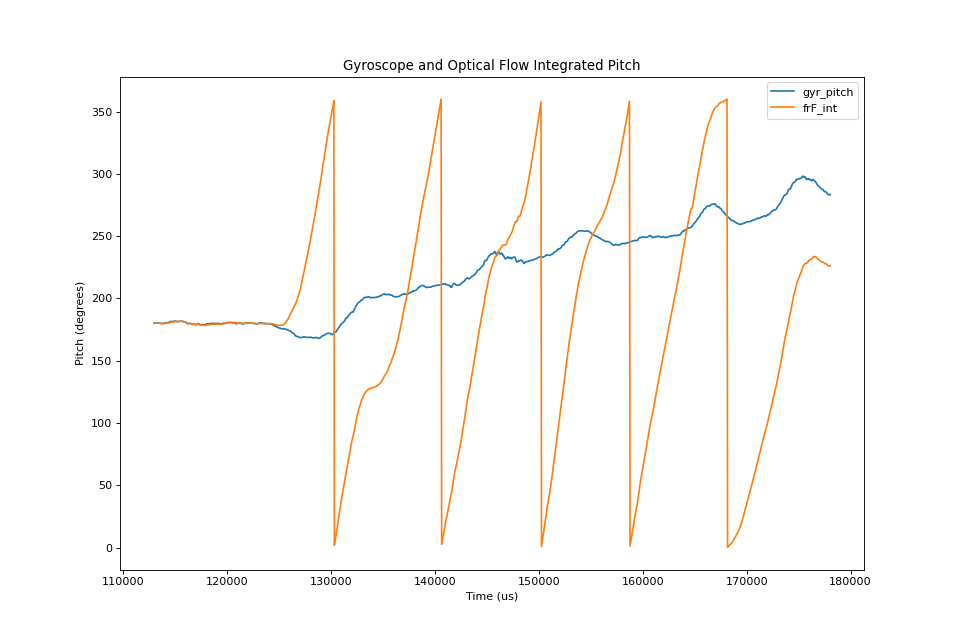

In [7]:
from confirmation.visualize import simple_time_plot
simple_time_plot([ofMS.ofMS[1:], ofMS.ofMS[1:]],
                 [gyr_of_pitch, of_pitch],
                 ["us","Pitch (degrees)"],
                 title="Gyroscope and Optical Flow Integrated Pitch")

Admittedly this looks bad but was expected. In the 
[simulation notebook](./0.1-bks-exploration.ipynb) from early on in the
analysis it was shown that integrating the flow rate of the optical flow
pitch to get change in attitude wouldn't work. We even see the same graph shape
in the simulation notebook, matching actual results to simulated expectations.
Even accounting for body rate the optical flow sensor will be reading the flow
of the ground plane and have a consistent reading as shown in the graph above.

#### Notes for Optical Flow pitch confirmation
 * May be able to correct for pitch angle by correcting the optical flow velocity with another sensors velocity and converting that reading to angular rate. This would require another sensor for velocity, i.e., GPS or Dead reckoning, and a ranging sensor
 * May look at using the change in perceived pitch angle instead of raw angle for confirmation

In [8]:
#Matching gyroscope to the optical flow update rate
gyr_of_roll = signal_match_and_cumsum(cUS.cUS[1:].reset_index(drop=True)/1000, change_in_signal((gyr_roll+180) % 360),
                            ofMS.ofMS[1:].reset_index(drop=True), change_in_signal((of_roll+180) % 360))

gyr_of_roll = pd.Series(gyr_of_roll, name="gyr_roll")

gyr_of_roll = (gyr_of_roll+180)%360
of_roll = (of_roll+180)%360
clear_output()

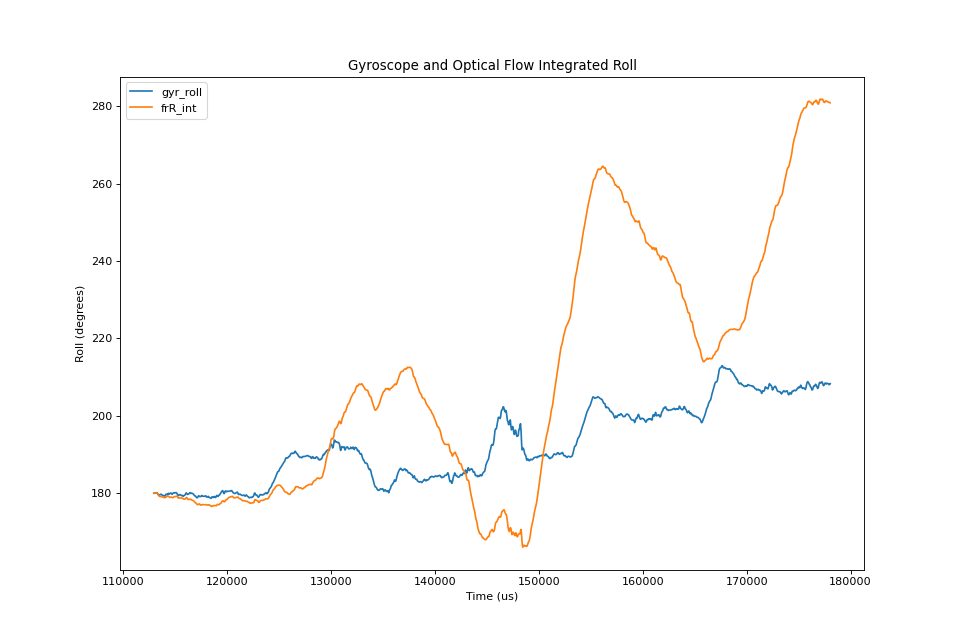

In [9]:
simple_time_plot([ofMS.ofMS[1:], ofMS.ofMS[1:]],
                 [gyr_of_roll, of_roll],
                 ["us","Roll (degrees)"],
                 title="Gyroscope and Optical Flow Integrated Roll")

### Gyroscope and Magnetometer

In [10]:
#We need the indexes that match the waypoint start and stop times
wp1_index = [magUS.magUS[magUS.magUS < WP1[0]][-1:].index[0], magUS.magUS[magUS.magUS < WP1[1]][-1:].index[0]]
wp2_index = [magUS.magUS[magUS.magUS < WP2[0]][-1:].index[0], magUS.magUS[magUS.magUS < WP2[1]][-1:].index[0]]
wp3_index = [magUS.magUS[magUS.magUS < WP3[0]][-1:].index[0], magUS.magUS[magUS.magUS < WP3[1]][-1:].index[0]]
wp4_index = [magUS.magUS[magUS.magUS < WP4[0]][-1:].index[0], magUS.magUS[magUS.magUS < WP4[1]][-1:].index[0]]
wp5_index = [magUS.magUS[magUS.magUS < WP5[0]][-1:].index[0], magUS.magUS[magUS.magUS < WP5[1]][-1:].index[0]]

#Matching gyroscope to the optical flow update rate
gyr_mag_pitch = signal_match_and_cumsum(cUS.cUS.reset_index(drop=True), change_in_signal((gyr_pitch+180)%360),
                                       magUS.magUS[1:].reset_index(drop=True), change_in_signal(mag_pitch))

gyr_mag_pitch = pd.Series(gyr_mag_pitch, name="gyr_pitch")
gyr_mag_pitch = (gyr_mag_pitch + 185) % 360
clear_output()

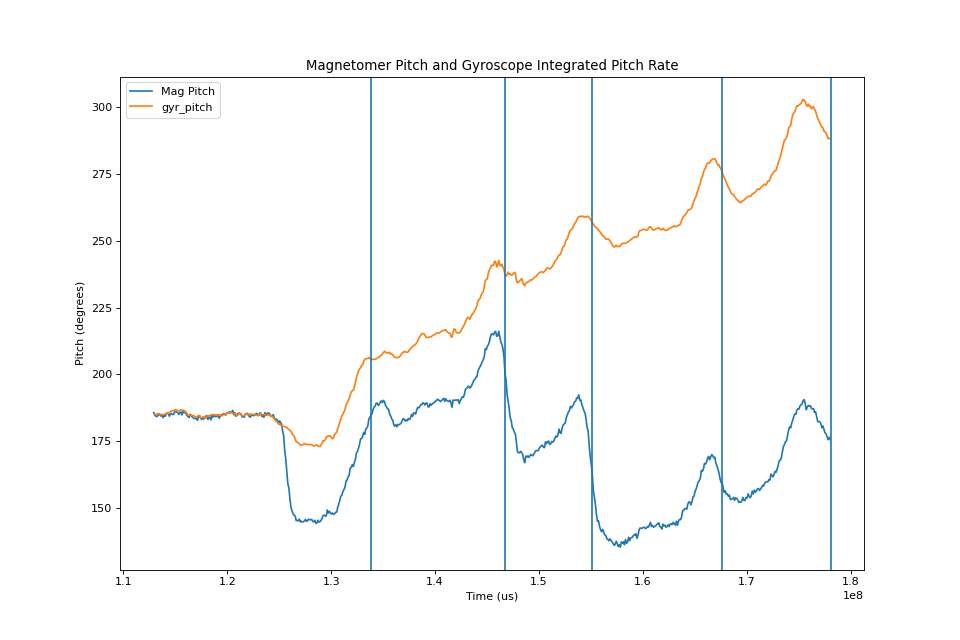

In [11]:
simple_time_plot([magUS.magUS, magUS.magUS[1:]],
                 [mag_pitch, gyr_mag_pitch],
                 ["us","Pitch (degrees)"],
                 lines=[WP1[1], WP2[1], WP3[1], WP4[1], WP5[1]],
                 title="Magnetomer Pitch and Gyroscope Integrated Pitch Rate")

This follows similarly to the optical flow and gyroscope pitch confirmation
from before in that the results from the 
[simulation notebook](./0.1-bks-exploration.ipynb) match what we are seeing
here. The notes for this confirmation still apply, where segments of activity
may be the target for confirmation rather than the absolute values. This could
also be the case where more engineering may be required since no filters have
been applied to the sensors. A sufficiently designed sensor may be able to
compensate for the drift we are seeing. This at least supports the results of
our simulations applying to reality.

#### Notes for Gyroscope pitch confirmation
 * May be able to correct for drift with a suitably designed filter, potentially a high-pass filter
 * May be viable to use a "categorical" approach for sensor confirmation, where the activity matches instead of the values

In [12]:
#Matching gyroscope to the optical flow update rate
gyr_mag_heading = signal_match_and_cumsum(cUS.cUS.reset_index(drop=True), change_in_signal((gyr_heading+180)%360),
                                       magUS.magUS[1:].reset_index(drop=True), change_in_signal(mag_heading))

gyr_mag_heading = pd.Series(gyr_mag_heading, name="gyr_heading")
gyr_mag_heading = (gyr_mag_heading+170)%360
mag_heading = (mag_heading+180)%360
clear_output()

In [13]:
simple_time_plot([magUS.magUS, magUS.magUS[1:]],
                 [mag_heading, gyr_mag_heading],
                 ["us", "Heading (degrees)"],
                 lines=[WP1[1], WP2[1], WP3[1], WP4[1], WP5[1]])
clear_output()

In [14]:
from confirmation.process import diff
print("Gyroscope and Magnetometer")
diffs = diff(gyr_mag_heading, mag_heading, wrap=True)
print("Heading | WP1 99.7%%: %.5f degrees" % np.percentile(diffs[wp1_index[0]:wp1_index[1]].dropna(), 99.7))
print("Heading | WP2 99.7%%: %.5f degrees" % np.percentile(diffs[wp2_index[0]:wp2_index[1]].dropna(), 99.7))
print("Heading | WP3 99.7%%: %.5f degrees" % np.percentile(diffs[wp3_index[0]:wp3_index[1]].dropna(), 99.7))
print("Heading | WP4 99.7%%: %.5f degrees" % np.percentile(diffs[wp4_index[0]:wp4_index[1]].dropna(), 99.7))
print("Heading | WP5 99.7%%: %.5f degrees" % np.percentile(diffs[wp5_index[0]:wp5_index[1]].dropna(), 99.7))

Gyroscope and Magnetometer
Heading | WP1 99.7%: 43.44313 degrees
Heading | WP2 99.7%: 76.98407 degrees
Heading | WP3 99.7%: 39.34930 degrees
Heading | WP4 99.7%: 49.21841 degrees
Heading | WP5 99.7%: 52.29211 degrees


So we are seeing another problem that came up in previous analysis in the
[simulation notebook](./0.1-bks-exploration.ipynb). During turns the
magnetometer has a tendency to start swinging. Because the simulation notebook
was using simulation data and the same behavior is present in the live data,
although less erratic, it makes me believe there is something unaccounted for
in the magnetometer heading calculation. Whether the calculation is incorrect
or there are external effects being simulated, i.e., magnetic field
fluctuations due to current draw, the current heading will have large error
margins. What is necessary is to see how these margins might compare to an
attacker spoofing the gyroscope or magnetometer and what disagreements
occur then.

#### Notes for Magnetometer heading confirmation
 * May be able to correct for drift with a suitably designed filter, potentially a low-pass filter
 * Consider using the magnet we have in lab to disrupt the magnetometer. Less of a spoofing attack but will still cause magnetic fluctuations from an outside source that we may use to detect an "attack"

## Position, Velocity, and Acceleration

In the [simulation exploration notebook](./0.1-bks-exploration.ipynb) the 
generic sensors used for position, velocity, and acceleration were discussed.
This section of the notebook will apply some of the discussed techniques as
well as introduce new ones that weren't implemented in teh simulation notebook.
Our main interest is the systems that provide navigation information such as
the dead reckoning system, optical flow system, and GPS. Some tertiary sensors
that can be leveraged for confirmation will be viewed as well, specifically
those discussed for altitude estimation in the
[rangefinder spoofing notebook](./0.1-bks-attack-idle-rf.ipynb).